In [1]:
# INFO 7390 Final Project
# NYC Airbnb Open Data 2020
# http://data.insideairbnb.com/united-states/ny/new-york-city/2020-10-05/visualisations/listings.csv

# Tasks:
# Data clusting
# Airbnb Price Prediction

# Columns:
# id - Listing ID
# name - Listing Title
# host_id - ID of Host
# host_name - Name of Host
# neighbourhood_group - Borough that contains listing
# neighbourhood - Name of neighbourhood that listing is in
# latitude - latitude of listing
# longitude - longitude of listing
# room_type - Type of public space that is being offered
# price - price per night, USD
# minimum_nights - minimum number of nights required to book listing
# number_of_reviews - total number of reviews that listing has accumulated
# last_review - date in which listing was last rented
# reviews_per_month - total number of reviews divided by the number of months the listing is active
# calculated_host_listings_count - amount of listing per host**
# availability_365 - number of days per year the listing is active


# Import Libaray and Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as st
from scipy import stats
from scipy.stats import norm, skew #for some statistics

from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
df=pd.read_csv('./listings.csv')
df.head()

id                                               name  host_id  \
0  2595                              Skylit Midtown Castle     2845   
1  3831  Whole flr w/private bdrm, bath & kitchen(pls r...     4869   
2  5121                                    BlissArtsSpace!     7356   
3  5136           Spacious Brooklyn Duplex, Patio + Garden     7378   
4  5178                   Large Furnished Room Near B'way　     8967   

     host_name neighbourhood_group       neighbourhood  latitude  longitude  \
0     Jennifer           Manhattan             Midtown  40.75362  -73.98377   
1  LisaRoxanne            Brooklyn        Clinton Hill  40.68514  -73.95976   
2        Garon            Brooklyn  Bedford-Stuyvesant  40.68688  -73.95596   
3      Rebecca            Brooklyn         Sunset Park  40.66120  -73.99423   
4     Shunichi           Manhattan      Hell's Kitchen  40.76489  -73.98493   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0  Entire home/apt    175               3                 48  2019-11-04   
1  Entire home/apt     76               1                354  2020-09-20   
2     Private room     60              29                 50  2019-12-02   
3  Entire home/apt    175               7                  1  2014-01-02   
4     Private room     73               2                473  2020-03-15   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.36                               2               365  
1               4.82                               1                 2  
2               0.36                               1                 2  
3               0.01                               1               359  
4               3.40                               1               350

In [4]:
df.shape

(44666, 16)

# Exploratory Data Analysis

In [5]:
'''check data types of all columns'''
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44666 entries, 0 to 44665
Data columns (total 16 columns):
id                                44666 non-null int64
name                              44650 non-null object
host_id                           44666 non-null int64
host_name                         44649 non-null object
neighbourhood_group               44666 non-null object
neighbourhood                     44666 non-null object
latitude                          44666 non-null float64
longitude                         44666 non-null float64
room_type                         44666 non-null object
price                             44666 non-null int64
minimum_nights                    44666 non-null int64
number_of_reviews                 44666 non-null int64
last_review                       34149 non-null object
reviews_per_month                 34149 non-null float64
calculated_host_listings_count    44666 non-null int64
availability_365                  44666 non-null int64

In [6]:
'''check null values'''
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            17
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10517
reviews_per_month                 10517
calculated_host_listings_count        0
availability_365                      0
dtype: int64

There are null values in name, host_name, last_review and reviews_per_month columns. Since the number of null values for last_review and reviews per month are same, so we can assume that those 10517 listings have not got any review, we will impute missing values with 0 for reviews_per_month columns later.

In [7]:
'''check room_type variable'''
ax = sns.countplot(x="room_type", data=df)

We can see that there are 4 room type, and most listings are Entire home or Private room.

In [8]:
'''check price for each room type'''
rt_price = df.groupby("room_type")["price"].mean()
rt_price

room_type
Entire home/apt    201.320954
Hotel room         311.175258
Private room        91.800956
Shared room        108.577174
Name: price, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

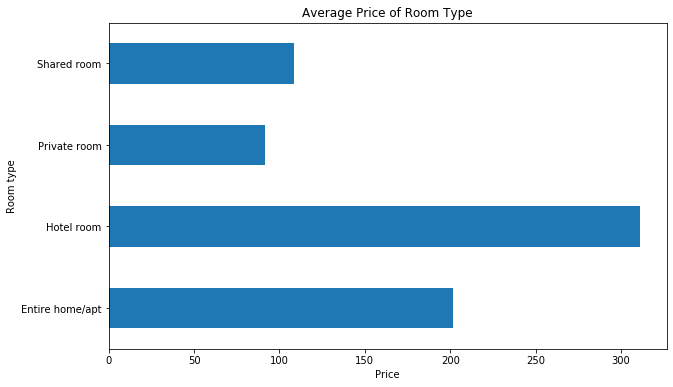

In [9]:
'''plot the average price for each room type'''
plt.figure(figsize = (10,6))
df.groupby('room_type')['price'].mean().plot(kind='barh')
plt.xlabel('Price')
plt.ylabel('Room type')
plt.title("Average Price of Room Type")
plt.show

We can see that Hotel room and Entire home are more expensive than Private room and Shared room, which makes sence.

In [10]:
'''check price distribution'''
plt.figure(figsize = (10,6))
plt.title('Price Distribution',fontsize=20)
sns.kdeplot(df['price'], shade='True', legend='True')

We can see that prices range from 0 to 10000. And from the plot we can observe that most of listings have price less than 500. And the graph shows that there is a positively skewed distribution. To make a better statisticial analysis and to get better scores, we will have applied log transformation for the price column later.

In [11]:
'''plot the price map of listing price < 500, we can see the distribution of prices more clearly'''
plt.figure(figsize=(10,6))
sns.scatterplot(df.longitude,df.latitude,hue=df["price"][df["price"]<500])
plt.ioff()

In [12]:
'''check neighbourhood_group variable'''
plt.figure(figsize = (10,6))
ax = sns.countplot(x="neighbourhood_group", data=df)

We can see that there are more Airbnb listings in Brookly and Manhattan. That make sence because Manhattan and Brookly are tourist area.

Text(0.5, 1.0, 'Average Price of Neighbourhood Groups')

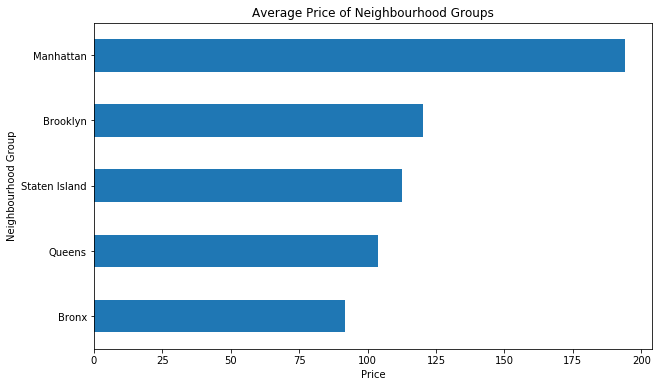

In [13]:
'''plot the average price for each neighbourhood group'''
plt.figure(figsize = (10,6))
ng_p_mean_df = df.groupby("neighbourhood_group")["price"].mean().sort_values().plot(kind='barh')
plt.xlabel("Price")
plt.ylabel("Neighbourhood Group")
plt.title("Average Price of Neighbourhood Groups")

We can see that average price in Manhattan is much higher than other neighbourhood groups.

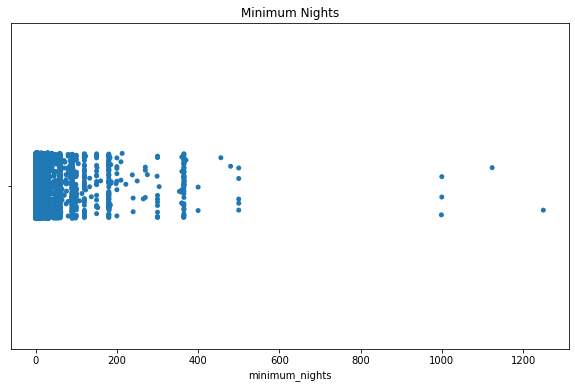

In [14]:
'''check minimum_nights variable'''
plt.figure(figsize = (10,6))
plt.title('Minimum Nights')
sns.stripplot(df['minimum_nights'])

We can see that minimum nights are between 0 night to 4 years. And most listings provide service ranging from 1 night to 1 year.

# Preprocessing data

Some columns are insignificant for data analysis and prediction model. "id", "name", "host_name" and "last_review" will not affect the housing prices. So we will drop those columns.

In [15]:
df.drop(['name','id','host_name','last_review'], axis=1, inplace=True)

In [16]:
df.head()

host_id neighbourhood_group       neighbourhood  latitude  longitude  \
0     2845           Manhattan             Midtown  40.75362  -73.98377   
1     4869            Brooklyn        Clinton Hill  40.68514  -73.95976   
2     7356            Brooklyn  Bedford-Stuyvesant  40.68688  -73.95596   
3     7378            Brooklyn         Sunset Park  40.66120  -73.99423   
4     8967           Manhattan      Hell's Kitchen  40.76489  -73.98493   

         room_type  price  minimum_nights  number_of_reviews  \
0  Entire home/apt    175               3                 48   
1  Entire home/apt     76               1                354   
2     Private room     60              29                 50   
3  Entire home/apt    175               7                  1   
4     Private room     73               2                473   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.36                               2               365  
1               4.82                               1                 2  
2               0.36                               1                 2  
3               0.01                               1               359  
4               3.40                               1               350

In [17]:
df.isnull().sum()

host_id                               0
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10517
calculated_host_listings_count        0
availability_365                      0
dtype: int64

We can see that we still have null values in reviews_per_month column, so we will impute missing values with 0 of reviews_per_month column.

In [18]:
df['reviews_per_month'].fillna(0, inplace=True)

In [19]:
'''check how many listings have price more than 500'''
df[df["price"]>500]

host_id neighbourhood_group       neighbourhood  latitude  longitude  \
61         74303            Brooklyn    Brooklyn Heights  40.69723  -73.99268   
117       165789            Brooklyn         Boerum Hill  40.68559  -73.98094   
192       291112           Manhattan             Chelsea  40.74358  -74.00027   
241       281229           Manhattan        Little Italy  40.71943  -73.99627   
276       116599            Brooklyn        Clinton Hill  40.68513  -73.96648   
...          ...                 ...                 ...       ...        ...   
44345   20515972           Manhattan      Hell's Kitchen  40.76080  -73.99431   
44385    9962257            Brooklyn          Greenpoint  40.72688  -73.95674   
44447  224210149           Manhattan         Murray Hill  40.74370  -73.97270   
44501  161268152            Brooklyn            Flatbush  40.63606  -73.96196   
44603  219517861           Manhattan  Financial District  40.70614  -74.01478   

             room_type  price  minimum_nights  number_of_reviews  \
61     Entire home/apt   2000               1                 25   
117    Entire home/apt    650               3                 23   
192    Entire home/apt    900               2                 35   
241    Entire home/apt    611               2                216   
276    Entire home/apt    650               5                  0   
...                ...    ...             ...                ...   
44345  Entire home/apt   1134               2                  0   
44385  Entire home/apt    795               5                  0   
44447  Entire home/apt   1575               3                  0   
44501  Entire home/apt   1000              30                  0   
44603  Entire home/apt    532               2                  0   

       reviews_per_month  calculated_host_listings_count  availability_365  
61                  0.21                               1               173  
117                 0.23                               1               365  
192                 0.29                               1               365  
241                 1.85                               1               333  
276                 0.00                               3               364  
...                  ...                             ...               ...  
44345               0.00                               1               365  
44385               0.00                               2               124  
44447               0.00                               1               364  
44501               0.00                               3               358  
44603               0.00                              37               360  

[1046 rows x 12 columns]

1046 listings have price per day > 1000. These are either super lavish listings or there was an error during input. Nonetheless, since this records are skewing our data a lot, we will treat them as outliers and drop them.

In [20]:
df=df[df["price"]<500]

In [21]:
df.iloc[:,3:].describe()

latitude     longitude         price  minimum_nights  \
count  43481.000000  43481.000000  43481.000000    43481.000000   
mean      40.729487    -73.950181    121.312550        9.284147   
std        0.055426      0.047595     81.728248       24.084408   
min       40.508680    -74.239860      0.000000        1.000000   
25%       40.689560    -73.982570     62.000000        2.000000   
50%       40.724020    -73.954780     99.000000        3.000000   
75%       40.763440    -73.932960    150.000000        7.000000   
max       40.911690    -73.711930    499.000000     1250.000000   

       number_of_reviews  reviews_per_month  calculated_host_listings_count  \
count       43481.000000       43481.000000                    43481.000000   
mean           22.761091           0.667534                        6.743520   
std            47.041984           1.170830                       25.135322   
min             0.000000           0.000000                        1.000000   
25%             1.000000           0.020000                        1.000000   
50%             4.000000           0.180000                        1.000000   
75%            20.000000           0.810000                        2.000000   
max           746.000000          41.370000                      239.000000   

       availability_365  
count      43481.000000  
mean         103.887859  
std          138.809880  
min            0.000000  
25%            0.000000  
50%            1.000000  
75%          180.000000  
max          365.000000

In [22]:
'''To make a better statisticial analysis and to get better scores, 
we will have applied log transformation for the price column.'''
df['price'] = np.log(df.price+1)

Text(0.5, 1.0, 'Log-Price Distribution Plot')

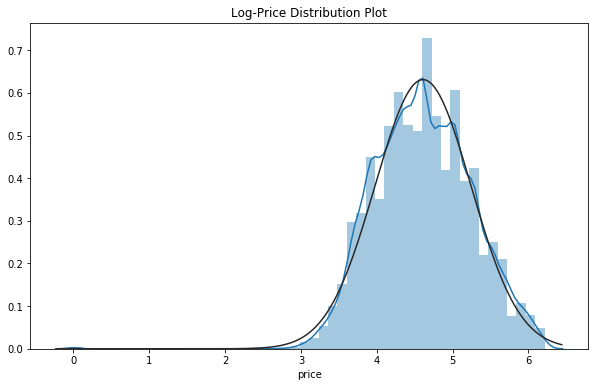

In [23]:
plt.figure(figsize=(10,6))
sns.distplot(df['price'], fit=norm)
plt.title("Log-Price Distribution Plot")

[(11, 0)]

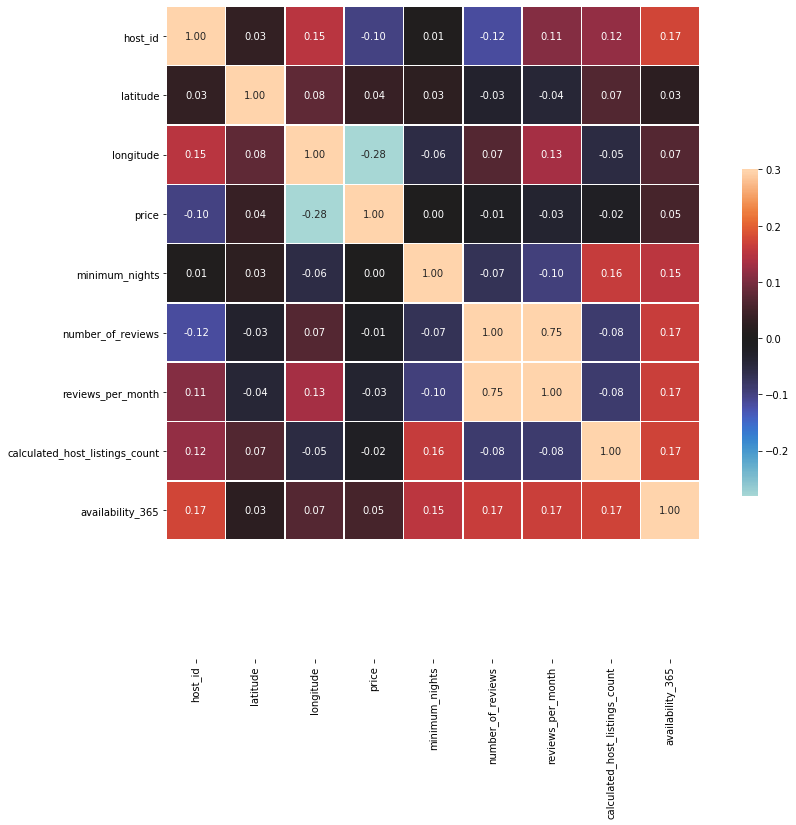

In [24]:
'''Correlation Matrix'''
plt.figure(figsize=(15,12))
corr=df.corr(method='pearson')
sns.heatmap(corr, annot=True, fmt=".2f", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(ylim=(11, 0))

# Encoding categorical variables

In [25]:
feature_columns=['neighbourhood_group','room_type','price','minimum_nights','calculated_host_listings_count','availability_365']
df2=df[feature_columns]
df2.head()

neighbourhood_group        room_type     price  minimum_nights  \
0           Manhattan  Entire home/apt  5.170484               3   
1            Brooklyn  Entire home/apt  4.343805               1   
2            Brooklyn     Private room  4.110874              29   
3            Brooklyn  Entire home/apt  5.170484               7   
4           Manhattan     Private room  4.304065               2   

   calculated_host_listings_count  availability_365  
0                               2               365  
1                               1                 2  
2                               1                 2  
3                               1               359  
4                               1               350

In [26]:
df2['room_type']=df2['room_type'].factorize()[0]
df2['neighbourhood_group']=df2['neighbourhood_group'].factorize()[0]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
df2.head()

neighbourhood_group  room_type     price  minimum_nights  \
0                    0          0  5.170484               3   
1                    1          0  4.343805               1   
2                    1          1  4.110874              29   
3                    1          0  5.170484               7   
4                    0          1  4.304065               2   

   calculated_host_listings_count  availability_365  
0                               2               365  
1                               1                 2  
2                               1                 2  
3                               1               359  
4                               1               350

# Train Test Split

In [28]:
y = df2['price']
x= df2.drop(['price'],axis=1)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.1,random_state=66)

# collect scores of each algorithm for model comparison
r_squared_test_score_dict = {}
mae_dict = {}
mse_dict = {}

# ML Algorithm 1: Linear Regression

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


model = LinearRegression()
model.fit(x_train,y_train)
y_pred=model.predict(x_test)

print('R-squared train score: {:.3f}'.format(model.score(x_train, y_train)))
print('R-squared test score: {:.3f}'.format(model.score(x_test, y_test)))
print('MAE:{:.3f}'.format(mean_absolute_error(y_test, y_pred)))
print('MSE:{:.3f}'.format(mean_squared_error(y_test, y_pred)))
print('RMSE:{:.3f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

R-squared train score: 0.362
R-squared test score: 0.372
MAE:0.392
MSE:0.268
RMSE:0.518


In [30]:
r_squared_test_score_dict['Liner Regression'] = model.score(x_test, y_test)
mae_dict['Liner Regression'] = mean_absolute_error(y_test, y_pred)
mse_dict['Liner Regression'] = mean_squared_error(y_test, y_pred)

In [31]:
error=pd.DataFrame(np.array(y_test).flatten(),columns=['actual'])
# expm1 is used to revert the data normalized by log1p
error['actual']=np.expm1(error['actual'])
error['prediction']=np.array(np.expm1(y_pred))
error.head(20)

actual  prediction
0     99.0   84.002538
1    105.0  125.490591
2    250.0  162.619605
3     64.0   73.466941
4     30.0   39.576533
5    120.0  155.004130
6     76.0  134.952702
7    200.0  121.328068
8    200.0  162.046097
9     57.0   61.867790
10    40.0   84.139853
11   115.0  127.190779
12    98.0  120.090357
13    70.0  172.517576
14    40.0   83.773084
15    71.0   59.504993
16   146.0  168.489210
17    46.0   78.660438
18    80.0   76.937255
19    50.0   71.047695

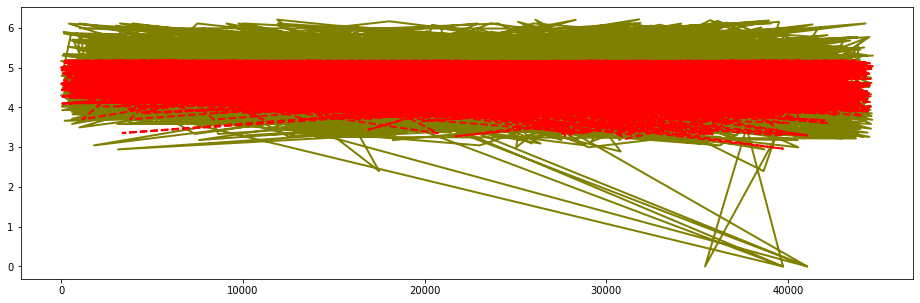

In [32]:
fig, axes = plt.subplots(figsize=(16,5))
_=axes.plot(y_test.index, y_test, marker='', color='olive', linewidth=2)
_=axes.plot(y_test.index, y_pred, marker='', color='r', linewidth=2, linestyle='dashed', label="predicted")

# ML Algorithm 2: Random Forest Regression 

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import joblib

In [35]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 6)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
# Create the random grid
rm_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [36]:
rf_model = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf_model, 
                                param_distributions = rm_grid, 
                                n_iter = 10, 
                                cv = 3, 
                                verbose=2, 
                                random_state=66,
                                n_jobs = -1)

In [37]:
# search for the best parameters
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   20.5s remaining:   20.5s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   28.9s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [38]:
rf_random.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [39]:
rf_model_best = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [40]:
rf_model_best.fit(x_train, y_train)
y_pred = rf_model_best.predict(x_test)

In [41]:
print('R-squared train score: {:.3f}'.format(model.score(x_train, y_train)))
print('R-squared test score: {:.3f}'.format(model.score(x_test, y_test)))
print('MAE:{:.3f}'.format(mean_absolute_error(y_test, y_pred)))
print('MSE:{:.3f}'.format(mean_squared_error(y_test, y_pred)))
print('RMSE:{:.3f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

R-squared train score: 0.362
R-squared test score: 0.372
MAE:0.340
MSE:0.200
RMSE:0.447


In [42]:
r_squared_test_score_dict['Random Forest'] = rf_model_best.score(x_test, y_test)
mae_dict['Random Forest'] = mean_absolute_error(y_test, y_pred)
mse_dict['Random Forest'] = mean_squared_error(y_test, y_pred)

In [43]:
error=pd.DataFrame(np.array(y_test).flatten(),columns=['actual'])
error['actual']=np.expm1(error['actual'])
error['prediction']=np.array(np.expm1(y_pred))
error.head(20)

actual  prediction
0     99.0   82.728768
1    105.0  122.681014
2    250.0  136.337598
3     64.0   67.711450
4     30.0   58.316163
5    120.0  156.170724
6     76.0  126.647265
7    200.0  126.866608
8    200.0  168.736620
9     57.0   54.433490
10    40.0   82.500335
11   115.0  137.585401
12    98.0  127.344123
13    70.0   88.284236
14    40.0   60.491586
15    71.0   50.638308
16   146.0  179.989802
17    46.0   50.569375
18    80.0   52.468393
19    50.0   62.017921

# ML Algorithm 3: Decision Tree Regression

In [44]:
from sklearn.tree import DecisionTreeRegressor

In [45]:
dtree_model = DecisionTreeRegressor();

In [46]:
dtree_model.fit(x_train, y_train)
y_pred = dtree_model.predict(x_test)

In [47]:
print('R-squared train score: {:.3f}'.format(dtree_model.score(x_train, y_train)))
print('R-squared test score: {:.3f}'.format(dtree_model.score(x_test, y_test)))
print('MAE:{:.3f}'.format(mean_absolute_error(y_test, y_pred)))
print('MSE:{:.3f}'.format(mean_squared_error(y_test, y_pred)))
print('RMSE:{:.3f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

R-squared train score: 0.700
R-squared test score: 0.419
MAE:0.370
MSE:0.248
RMSE:0.498


In [48]:
r_squared_test_score_dict['Decision Tree'] = dtree_model.score(x_test, y_test)
mae_dict['Decision Tree'] = mean_absolute_error(y_test, y_pred)
mse_dict['Decision Tree'] = mean_squared_error(y_test, y_pred)

In [49]:
error=pd.DataFrame(np.array(y_test).flatten(),columns=['actual'])
# expm1 is used to revert the data normalized by log1p
error['actual']=np.expm1(error['actual'])
error['prediction']=np.array(np.expm1(y_pred))
error.head(20)

actual  prediction
0     99.0   81.288142
1    105.0  124.979359
2    250.0   59.000000
3     64.0   65.483081
4     30.0   68.629307
5    120.0  140.541513
6     76.0   99.000000
7    200.0  125.919136
8    200.0  149.884704
9     57.0   36.000000
10    40.0   82.209964
11   115.0  142.083713
12    98.0   80.000000
13    70.0   74.000000
14    40.0   41.000000
15    71.0   37.591263
16   146.0  232.000000
17    46.0   54.000000
18    80.0   68.000000
19    50.0   62.264897

In [50]:
plt.figure(figsize=(10,10))
sns.regplot(y=np.array(np.expm1(y_pred)), x=np.array(np.expm1(y_test)), line_kws={"color": "red"}, color='springgreen')
plt.title('Evaluated predictions', fontsize=15)
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.show()

In [51]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,8))
ax1.scatter(np.array(np.expm1(y_test)),np.expm1(y_pred))
ax1.set_xlabel("True", size = 14)
ax1.set_ylabel("Prediction", size = 14)
ax2.plot(np.array(np.expm1(y_test)), label="True")
ax2.plot(np.expm1(y_pred), label = "Prediction")
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 12})

# Model Comparison

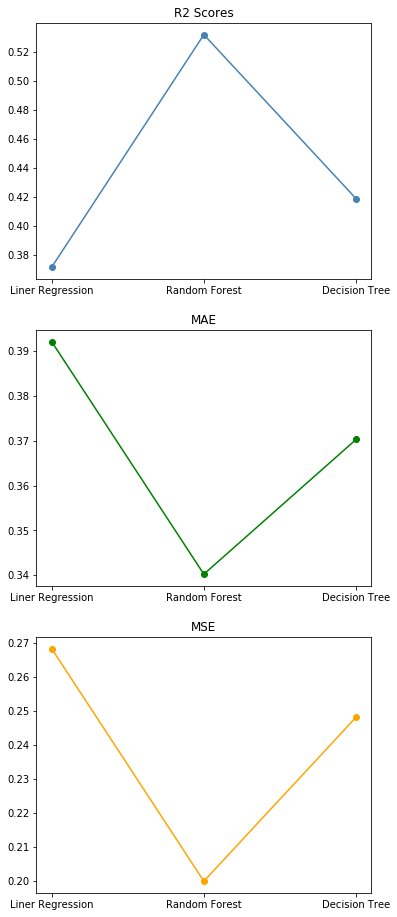

In [60]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1 ,figsize = (6, 16))
ax1.set_title("R2 Scores")
ax1.plot(list(r_squared_test_score_dict.keys()), list(r_squared_test_score_dict.values()), marker = "o", color = "steelblue")
ax2.set_title("MAE")
ax2.plot(list(mae_dict.keys()), list(mae_dict.values()), marker = "o", color = "green")
ax3.set_title("MSE")
ax3.plot(list(mse_dict.keys()), list(mse_dict.values()), marker = "o", color = "orange")